In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
#     temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
#     temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
#     temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

In [3]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/FW_temperature_cleared.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv',
                       mortality_path='../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow

temperature = dataframes['temperature']
temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
temperature['event_year'] = temperature['event_date'].dt.year

locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']

sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

In [4]:
lw_dates = locus_weights.groupby('final_locus_population_id').agg({'starttime': 'min', 'endtime': 'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime, format=TIME_FORMAT)
lw_dates.endtime = pd.to_datetime(lw_dates.endtime, format=TIME_FORMAT)
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days + 1  # to be checked (?)
lw_dates['starttime_year'] = lw_dates['starttime'].dt.year
lw_dates = lw_dates[lw_dates.starttime_year>=2017]  # issues with temperature readings for 2015-2016

In [5]:
final_locus_locus_group_weighted = final_locus_weighted.merge(locus_group_matching,
                                                              left_on='historic_locus_id',
                                                              right_on='locus_id',
                                                              how='left')
final_locus_locus_group_weighted.drop(columns='locus_id',inplace=True)

## Analysis

In [6]:
# treatment = pd.read_csv('data/evt_treatment.csv')
treatment = pd.read_csv('../data/evt_treatment_UPS_Petrohue.csv')
# treatment_len = pd.read_csv('./data/treatment_length.csv', encoding='windows-1252')
# treatment_len_reason = pd.read_csv('data/treatment_length_with_reason.csv', encoding='windows-1252')
substance = pd.read_csv('../data/lkp_active_substance.csv', sep='\t', encoding='windows-1252')
treatment_lkp = pd.read_csv('../data/lkp_treatment_method.csv', sep='\t', encoding='windows-1252')
tarp_lkp = pd.read_csv('../data/lkp_tarp_type.csv', sep='\t', encoding='windows-1252')

substance.rename(columns={'id': 'active_substance_id'}, inplace=True)
substance.rename(columns={'name': 'active_substance_name'}, inplace=True)

treatment_lkp.rename(columns={'id': 'treatment_method_id'}, inplace=True)
treatment_lkp.rename(columns={'name': 'treatment_method_name'}, inplace=True)

tarp_lkp.rename(columns={'id': 'tarp_type_id'}, inplace=True)
tarp_lkp.rename(columns={'name': 'tarp_type_name'}, inplace=True)


treatment = treatment.merge(
    substance[['active_substance_id', 'active_substance_name']], how='left', on='active_substance_id')

treatment = treatment.merge(
    treatment_lkp[['treatment_method_id', 'treatment_method_name']], how='left', on='treatment_method_id')

treatment = treatment.merge(
    tarp_lkp[['tarp_type_id', 'tarp_type_name']], how='left', on='tarp_type_id')

treatment['event_date'] = pd.to_datetime(treatment['event_date'])
treatment['event_year'] = treatment['event_date'].dt.year

treatment_diff = treatment.groupby(['locus_id', 'locus_population_id', 'prescription', 'treatment_method_id'])['event_date'].agg(['max','min']).reset_index()
treatment_diff['duration'] = treatment_diff['max'] - treatment_diff['min']

In [7]:
treatment.prescription.value_counts()

prescription
-               52728
PMV14RPH2015      562
PMV3RPH2018       519
PMV6RPH2017       513
.                 452
                ...  
CP0119SUPS          1
PMV2UPS2016         1
CP0015SUPS          1
CP0019SUPS          1
PMV11UPS2017        1
Name: count, Length: 316, dtype: int64

### Treatment

#### General

In [222]:
def boxplot_feature(df, agg_func, feature, hue, target='amount'):
    grouped_df = pd.DataFrame(df.groupby([feature, hue])[target].apply(lambda x: agg_func(x))).reset_index()
    return grouped_df
    fig = sns.boxplot(data=grouped_df, x=feature, y=target, hue=hue)
    for item in fig.get_xticklabels():
        item.set_rotation(45)
        item.set_horizontalalignment('right')
        
    plt.title(f'{agg_func.__name__} {target} vs. {feature} by {hue}')
    plt.show()

def barplot_feature(df, agg_func, feature, target='amount', hue=None):
    if hue:
        grouped_df = pd.DataFrame(df.groupby([feature, hue])[target].apply(lambda x: agg_func(x))).reset_index()
    else:
        grouped_df = pd.DataFrame(df.groupby(feature)[target].apply(lambda x: agg_func(x))).reset_index()
        
    fig = sns.barplot(data=grouped_df, x=feature, y=target, hue=hue)
    for item in fig.get_xticklabels():
        item.set_rotation(45)
        item.set_horizontalalignment('right')
    by_hue = f' by {hue}' if hue else '' 
    
    plt.title(f'{agg_func.__name__} {target} vs. {feature}{by_hue}')
    plt.show()

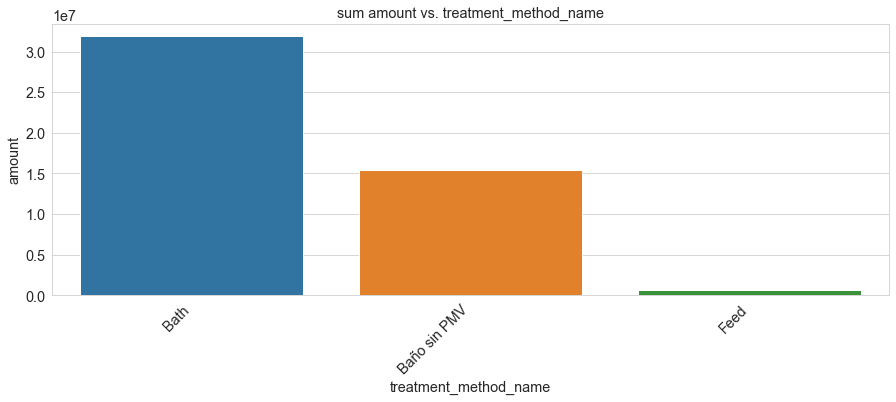

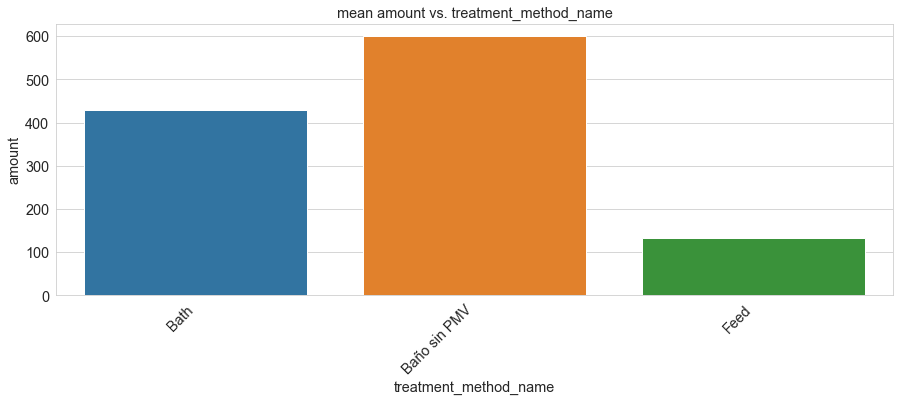

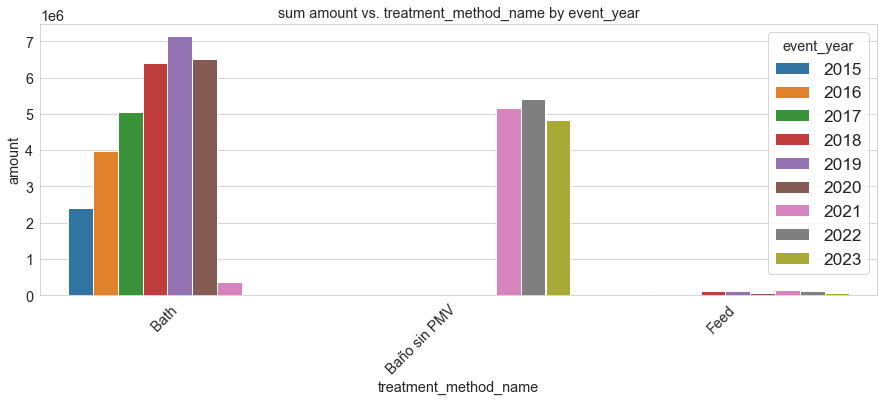

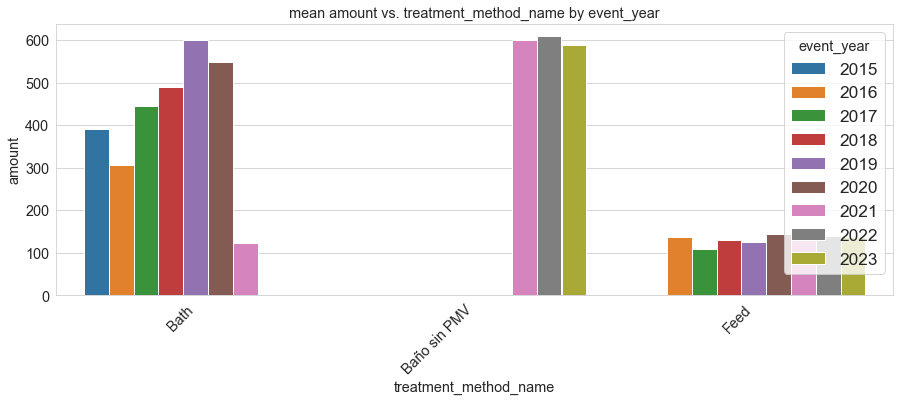

In [223]:
barplot_feature(treatment, np.sum, 'treatment_method_name')
barplot_feature(treatment, np.mean, 'treatment_method_name')

barplot_feature(treatment, np.sum, 'treatment_method_name', hue='event_year')
barplot_feature(treatment, np.mean, 'treatment_method_name', hue='event_year')

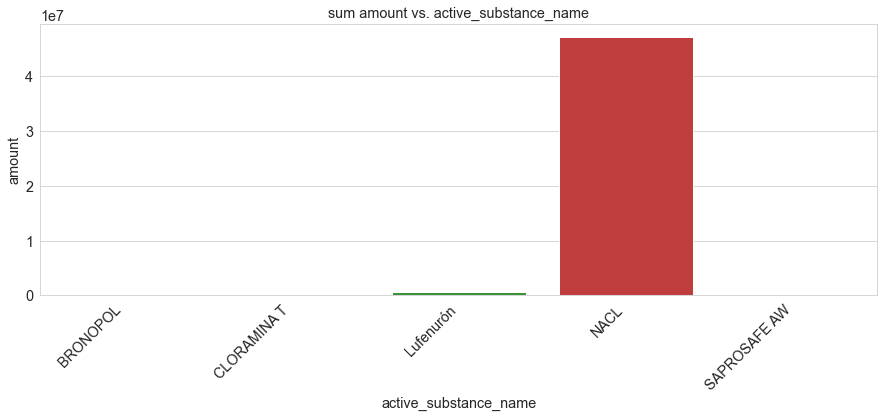

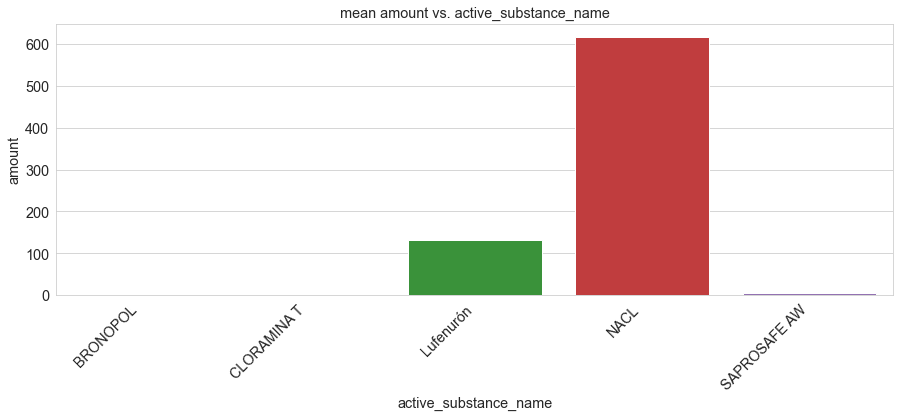

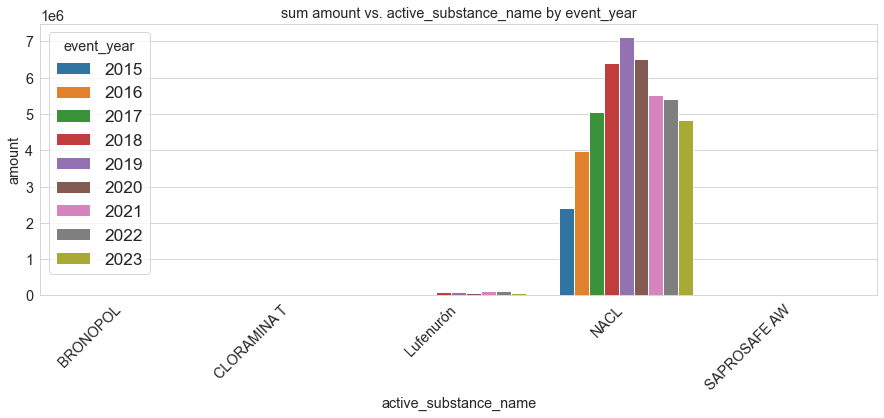

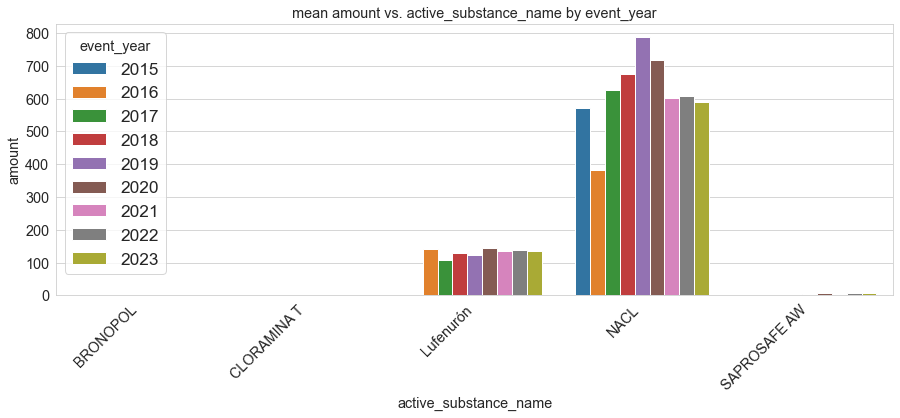

In [224]:
barplot_feature(treatment, np.sum, 'active_substance_name')
barplot_feature(treatment, np.mean, 'active_substance_name')

barplot_feature(treatment, np.sum, 'active_substance_name', hue='event_year')
barplot_feature(treatment, np.mean, 'active_substance_name', hue='event_year')

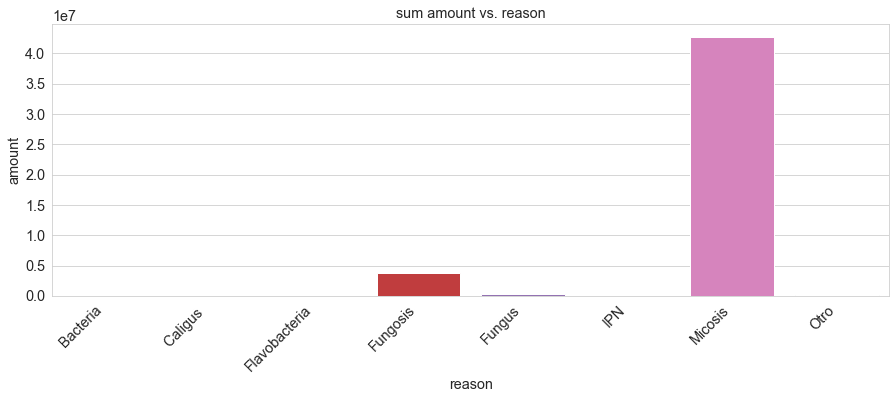

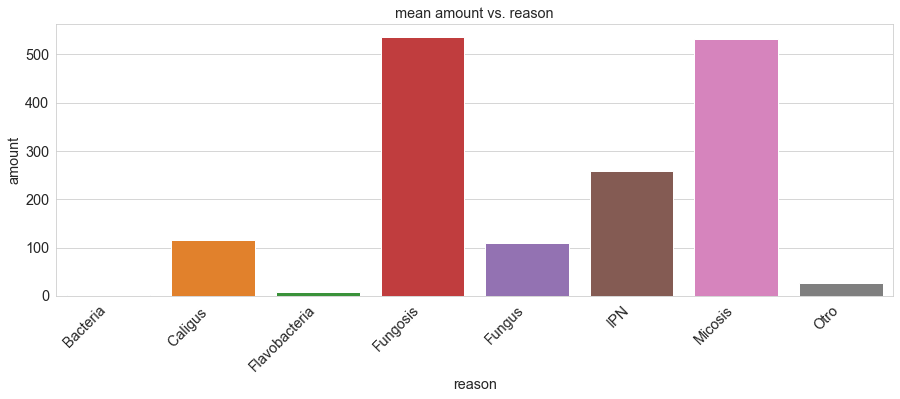

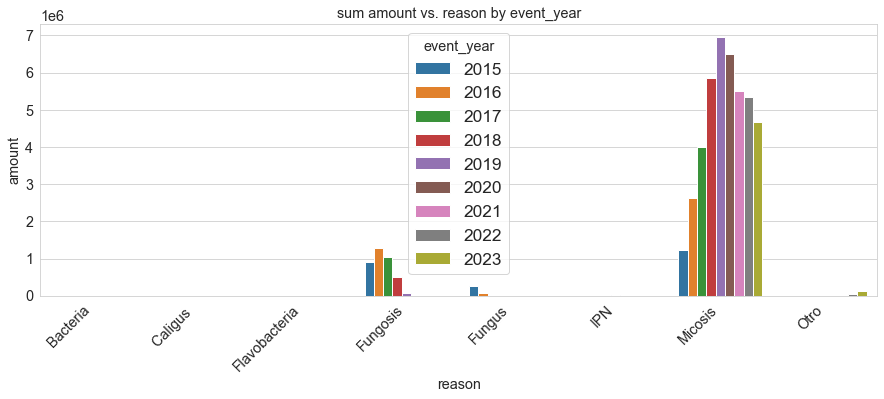

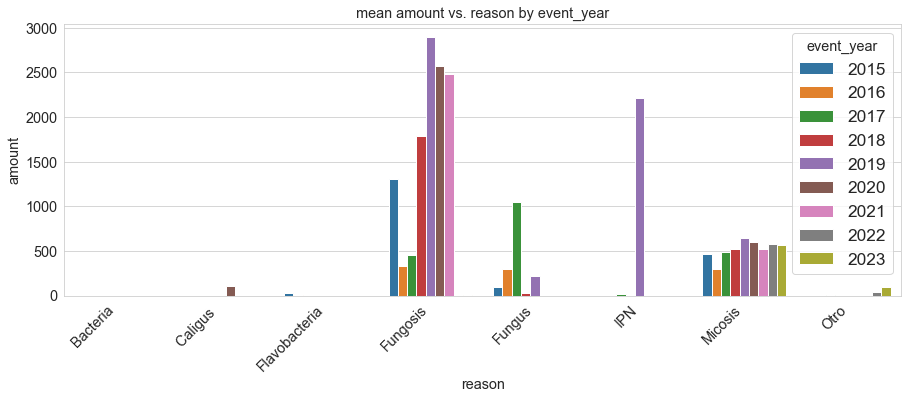

In [225]:
barplot_feature(treatment, np.sum, 'reason')
barplot_feature(treatment, np.mean, 'reason')

barplot_feature(treatment, np.sum, 'reason', hue='event_year')
barplot_feature(treatment, np.mean, 'reason', hue='event_year')

In [226]:
treatment['prescription'].unique().shape

(317,)

#### On levels

In [227]:
def barplot_feature_l_lp(df, feature):
    """
        Displays number of unique occurences of each
        feature element on locus-locus_population level.
    """
    
    feature_count = pd.DataFrame(
        df.groupby(['locus_id', 'locus_population_id'])[feature].apply(
            lambda x: pd.value_counts(x.unique())
        )
    )

    feature_count.reset_index(inplace=True)
    feature_count.rename(columns={feature: 'count'}, inplace=True)
    feature_count.rename(columns={'level_2': feature}, inplace=True)
    feature_count = feature_count.groupby(feature)['count'].sum()
    feature_count = pd.DataFrame(feature_count).reset_index()

    fig = sns.barplot(data=pd.DataFrame(feature_count).reset_index(), x=feature, y='count')

    for item in fig.get_xticklabels():
        item.set_rotation(45)
        item.set_horizontalalignment('right')

In [228]:
def barplot_feature_l_lp(df, feature):
    """
        Displays treatment amount sum of each
        feature element on locus-locus_population level.
    """
    
    feature_count = pd.DataFrame(
        df.groupby(['locus_id', 'locus_population_id'])[feature].apply(
            lambda x: pd.value_counts(x.unique())
        )
    )

    feature_count.reset_index(inplace=True)
    feature_count.rename(columns={feature: 'count'}, inplace=True)
    feature_count.rename(columns={'level_2': feature}, inplace=True)
    feature_count = feature_count.groupby(feature)['count'].sum()
    feature_count = pd.DataFrame(feature_count).reset_index()

    fig = sns.barplot(data=pd.DataFrame(feature_count).reset_index(), x=feature, y='count')

    for item in fig.get_xticklabels():
        item.set_rotation(45)
        item.set_horizontalalignment('right')

In [229]:
# pd.DataFrame(
#     treatment.groupby(['locus_id', 'reason'])['amount'].sum()
# )

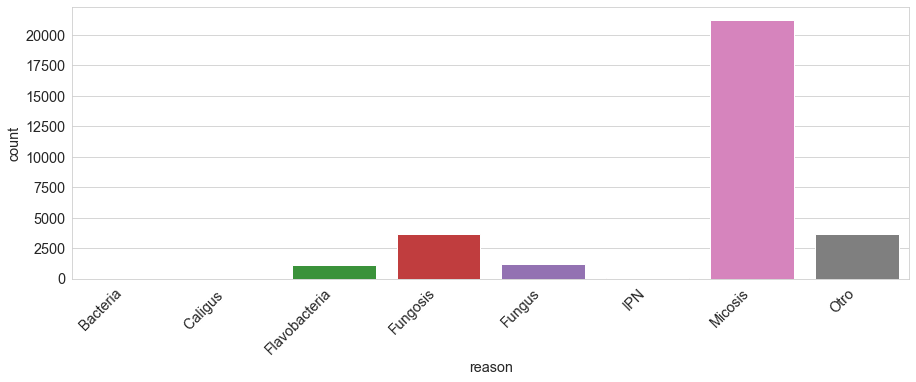

In [230]:
barplot_feature_l_lp(treatment, 'reason')

In [ ]:
barplot_feature_l_lp(treatment, 'treatment_method_name')

In [ ]:
barplot_feature_l_lp(treatment, 'active_substance_name')

### Processing

In [9]:
na_list = [x for x in treatment.prescription.dropna().unique() if len(x)<5]
treatment['prescription'] = treatment['prescription'].replace(na_list, np.nan)
treatment['prescription'] = treatment['prescription'].str.upper()
treatment['prescription'] = treatment['prescription'].replace(' M0002APHU', 'LM0002APHU')
treatment['prescription'] = treatment['prescription'].fillna(0)

In [10]:
fungosis_list = ['fungus','fumgosis','funosis','fungodid']
flavobacteria_list = ['flavobacteriosis','flavobacterosis','flabobacteriosis','bacteria','flabovacteriosis']

treatment['reason'] = treatment['reason'].str.lower()
treatment['reason'] = treatment['reason'].replace(fungosis_list, 'fungosis')
treatment['reason'] = treatment['reason'].replace(flavobacteria_list, 'flavobacteria')
treatment['reason'] = treatment['reason'].fillna(0)

In [11]:
treatment['reason'].unique()

array(['micosis', 0, 'fungosis', 'flavobacteria', 'otro', 'ipn',
       'caligus '], dtype=object)

In [12]:
treatment['prescription'].unique()

array([0, 'CP0008SUPS', 'CP0061SUPS', 'CP0052SUPS', 'CP0071SUPS',
       'LJ0012SUPS', 'LJ0018SUPS', 'LM0007SUPS', 'PMV01RPH2015',
       'PMV05RPH2015', 'PMV13RPH2015', 'PMV14RPH2015', 'PMV3RPH2016',
       'PMV4RPH2016', 'PMV12RPH2015', 'CP0012APHU', 'CP0020APHU',
       'CP0022APHU', 'CP0026APHU', 'CP0029APHU', 'CP0032APHU',
       'CP0034APHU', 'CP0053APHU', 'CP0055APHU', 'CP0057APHU',
       'CP0061APHU', 'LJ0001APHU', 'LJ0005APHU', 'LJ0008APHU',
       'LJ0010APHU', 'LM0003APHU', 'CP0020SUPS', 'CP0033SUPS',
       'CP0053SUPS', 'CP0066SUPS', 'CP0086SUPS', 'CP0089SUPS',
       'CP0102SUPS', 'FB0018SUPS', 'PMV5RPH2016', 'PMV1RPH2017',
       'PMV4RPH2017', 'PMV6RPH2017', 'PMV15RPH2017', 'PMV17RPH2017',
       'PMV4RPH2018', 'PMV6RPH2018', 'CP0025APHU', 'CP0030APHU',
       'CP0038APHU', 'CP0039APHU', 'CP0048APHU', 'CP0050APHU',
       'CP0056APHU', 'CP0066APHU', 'LJ0002APHU', 'LJ0021APHU',
       'FB0003APHU', 'LM0018APHU', 'LM0020APHU', 'PMV30UPS2018',
       'PMV2UPS2019', 'CP003

In [13]:
treatment_grouped = treatment.groupby(
    ['prescription', 'reason', 'treatment_method_id', 'locus_population_id', 'locus_id']
).agg({'amount': 'sum',
       'active_substance_name': lambda col: col.mode().iloc[0] if len(col.mode()) > 0 else np.nan,
      'treatment_method_name': lambda col: col.mode().iloc[0] if len(col.mode()) > 0 else np.nan,
      'tarp_type_name': lambda col: col.mode().iloc[0] if len(col.mode()) > 0 else np.nan,
      'event_date': ['min', 'max']
      }).reset_index()

treatment_grouped.columns = ['prescription', 'reason', 'treatment_method_id', 'locus_population_id', 'locus_id',
                             'amount', 'active_substance_name', 'treatment_method_name', 'tarp_type_name',
                             'min_event_date', 'max_event_date']

treatment_grouped['duration'] = (treatment_grouped['max_event_date'] - treatment_grouped['min_event_date']).dt.total_seconds() / (60 * 60 * 24)
treatment_grouped['min_event_date_year'] = treatment_grouped['min_event_date'].dt.year


In [14]:
# treatment_grouped_2015#[['prescription', 'reason', 'treatment_method_id']].value_counts().to_csv('data\\check_val_kkey.csv')

In [15]:
# __ = _.merge(
#     treatment_len_reason_,
#     how='right',
#     on=['prescription', 'reason', 'treatment_method_id', 'locus_population_id' ,'locus_id']
# )

# # __['event_year'] = pd.to_datetime(treatment_grouped['max_date']).dt.year

In [16]:
# len(treatment_len_reason_),len(_),len(__)

In [17]:
# _

In [18]:
# __

In [19]:
# __filtered = __[__['min_date'] > '2015-01-01']

In [20]:
# nans = __filtered[__filtered['amount'].isna()]

In [21]:
# _[_['locus_population_id'] == 36787705]

In [22]:
# __[__['locus_population_id'] == 36787705]

In [23]:
# treatment_grouped = treatment.groupby(
#     ['prescription', 'reason', 'treatment_method_id', 'locus_population_id', 'locus_id']
# ).agg({'amount': 'sum',
#        'active_substance_name': lambda col: col.mode().iloc[0] if len(col.mode()) > 0 else np.nan,
#       'treatment_method_name': lambda col: col.mode().iloc[0] if len(col.mode()) > 0 else np.nan,
#       'tarp_type_name': lambda col: col.mode().iloc[0] if len(col.mode()) > 0 else np.nan}).reset_index()

In [24]:
# treatment_grouped = treatment_grouped.merge(
#     treatment_len_reason,
#     how='inner',
#     on=['prescription', 'reason', 'treatment_method_id', 'locus_population_id' ,'locus_id']
# )

# treatment_grouped['event_year'] = pd.to_datetime(treatment_grouped['max_date']).dt.year

In [25]:
# if False:
#     treatment = treatment[treatment['event_date'].between(treatment['min_date'], treatment['max_date'])]

#     treatment['max_date'] = pd.to_datetime(treatment['max_date'])
#     treatment['min_date'] = pd.to_datetime(treatment['min_date'])
#     treatment['duration'] = treatment['max_date'] - treatment['min_date']
#     treatment['duration'] = treatment['duration'].apply(
#         lambda x: x.total_seconds() / datetime.timedelta(days=1).total_seconds()
#     )

# print(treatment_grouped['duration_days'])
    
# treatment_methods = treatment_grouped['treatment_method_name'].unique()
# treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['treatment_method_name']))
# for method in treatment_methods:
#     treatment_grouped[method] = treatment_grouped[method] * treatment_grouped['duration_days']
#     treatment_grouped.rename(columns={method: f'{method}_duration'}, inplace=True)
    
# print(treatment_grouped['duration_days'])
    
# active_substances = treatment_grouped['active_substance_name'].dropna().unique()
# treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['active_substance_name']))
# for substance in active_substances:
#     treatment_grouped[substance] = treatment_grouped[substance] * treatment_grouped['duration_days']
#     treatment_grouped.rename(columns={substance: f'{substance}_duration'}, inplace=True)

# print(treatment_grouped['duration_days'])

# treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment['active_substance_name']))
# for substance in active_substances:
#     treatment_grouped[substance] = treatment_grouped[substance] * treatment_grouped['amount']
#     treatment_grouped.rename(columns={substance: f'{substance}_amount'}, inplace=True)

# print(treatment_grouped['duration_days'])
    
# tarp_names = treatment_grouped['tarp_type_name'].dropna().unique()
# treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['tarp_type_name']))
# for tarp_name in tarp_names:
#     treatment_grouped[tarp_name] = treatment_grouped[tarp_name] * treatment_grouped['duration_days']
#     treatment_grouped.rename(columns={tarp_name: f'{tarp_name}_duration'}, inplace=True)

# print(treatment_grouped['duration_days'])
    
# treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['tarp_type_name']))
# for tarp_name in tarp_names:
#     treatment_grouped[tarp_name] = treatment_grouped[tarp_name] * treatment_grouped['amount']
#     treatment_grouped.rename(columns={tarp_name: f'{tarp_name}_amount'}, inplace=True)

In [26]:
treatment_grouped

,prescription,reason,treatment_method_id,locus_population_id,locus_id,amount,active_substance_name,treatment_method_name,tarp_type_name,min_event_date,max_event_date,duration,min_event_date_year
0,0,0,1,36760607,3051354,2854.0,NACL,Bath,WellBoat,2015-02-11 09:40:00,2015-02-11 09:40:00,0.0,2015
1,0,0,1,36761202,3051487,2069.0,NACL,Bath,WellBoat,2015-02-11 09:15:00,2015-02-11 09:15:00,0.0,2015
2,0,0,1,36761237,3048893,2066.0,NACL,Bath,WellBoat,2015-02-11 10:00:00,2015-02-11 10:00:00,0.0,2015
3,0,0,1,36761448,3051395,2947.0,NACL,Bath,WellBoat,2015-03-23 11:30:00,2015-03-23 11:30:00,0.0,2015
4,0,0,1,36761904,3048387,3832.0,NACL,Bath,WellBoat,2015-03-23 10:40:00,2015-03-23 10:40:00,0.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37324,PMVRPH12016,micosis,1,36767563,3050098,0.1,BRONOPOL,Bath,WellBoat,2016-01-07 00:00:00,2016-01-07 00:00:00,0.0,2016
37325,RR0003SUPS,0,2,36792716,3046161,840.0,Lufenurón,Feed,NaN,2019-06-11 00:00:00,2019-06-14 00:00:00,3.0,2019
37326,RR0003SUPS,0,2,36793727,3049988,880.0,Lufenurón,Feed,NaN,2019-06-08 00:00:00,2019-06-14 00:00:00,6.0,2019
37327,RR0003SUPS,0,2,36793739,3050085,800.0,Lufenurón,Feed,NaN,2019-06-10 00:00:00,2019-06-14 00:00:00,4.0,2019


In [27]:
treatment_methods = treatment_grouped['treatment_method_name'].unique()
treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['treatment_method_name']))
for method in treatment_methods:
    treatment_grouped[method] = treatment_grouped[method] * treatment_grouped['duration']
    treatment_grouped.rename(columns={method: f'{method}_duration'}, inplace=True)

In [28]:
active_substances = treatment_grouped['active_substance_name'].dropna().unique()
treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['active_substance_name']))
for substance in active_substances:
    treatment_grouped[substance] = treatment_grouped[substance] * treatment_grouped['duration']
    treatment_grouped.rename(columns={substance: f'{substance}_duration'}, inplace=True)

In [29]:
tarp_names = treatment_grouped['tarp_type_name'].dropna().unique()
treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['tarp_type_name']))
for tarp_name in tarp_names:
    treatment_grouped[tarp_name] = treatment_grouped[tarp_name] * treatment_grouped['duration']
    treatment_grouped.rename(columns={tarp_name: f'{tarp_name}_duration'}, inplace=True)

In [30]:
treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment['active_substance_name']))
for substance in active_substances:
    treatment_grouped[substance] = treatment_grouped[substance] * treatment_grouped['amount']
    treatment_grouped.rename(columns={substance: f'{substance}_amount'}, inplace=True)

In [31]:
# treatment_grouped = treatment_grouped.join(pd.get_dummies(treatment_grouped['tarp_type_name']))
# for tarp_name in tarp_names:
#     treatment_grouped[tarp_name] = treatment_grouped[tarp_name] * treatment_grouped['amount']
#     treatment_grouped.rename(columns={tarp_name: f'{tarp_name}_amount'}, inplace=True)

In [32]:
treatment_grouped_full = treatment_grouped.copy()

In [33]:
treatment_grouped = treatment_grouped[treatment_grouped.min_event_date_year>=2015]

In [42]:
treatment_grouped.columns

Index(['prescription', 'reason', 'treatment_method_id', 'locus_population_id',
       'locus_id', 'amount', 'active_substance_name', 'treatment_method_name',
       'tarp_type_name', 'min_event_date', 'max_event_date', 'duration',
       'min_event_date_year', 'Bath_duration', 'Baño sin PMV_duration',
       'Feed_duration', 'BRONOPOL_duration', 'CLORAMINA T_duration',
       'Lufenurón_duration', 'NACL_duration', 'SAPROSAFE AW_duration',
       'WellBoat_duration', 'BRONOPOL_amount', 'CLORAMINA T_amount',
       'Lufenurón_amount', 'NACL_amount', 'SAPROSAFE AW_amount'],
      dtype='object')

In [35]:
# treatment_grouped.drop(columns='Enclosed Tarpaulin_amount').iloc[:,:-3].to_csv('data\\treatment_data_grouepd_on_prescription_reason_level.csv',index=False)

In [36]:
print(na_list)
pd.DataFrame(treatment_grouped[['reason','min_event_date_year']].value_counts().reset_index())

['-', '.', '.-', '_', '--', '-{', ':']


,reason,min_event_date_year,count
0,micosis,2018,3395
1,micosis,2021,3382
2,micosis,2020,3315
3,micosis,2017,3054
4,micosis,2019,2973
5,micosis,2016,2604
6,micosis,2022,2444
7,micosis,2023,2417
8,fungosis,2016,1722
9,fungosis,2017,1492


In [37]:
print(na_list)
pd.DataFrame(treatment_grouped[['prescription','min_event_date_year']].value_counts().reset_index()).to_csv('../data\\presc_counts.csv')

['-', '.', '.-', '_', '--', '-{', ':']


In [38]:
if True:    
#     group_treatment_cols = ['prescription', 'reason', 'event_year', 'locus_population_id', 'locus_id', 'treatment_method_id']
#     group_treatment_cols = ['prescription', 'reason', 'min_event_date_year', 'locus_population_id', 'locus_id', 'treatment_method_id']
    group_treatment_cols = ['reason', 'min_event_date_year']

    
    
    total_duration = pd.DataFrame(treatment_grouped.groupby(group_treatment_cols)['duration'].sum())
    total_duration.rename(columns={'duration_x': 'duration'}, inplace=True)

    total_number = pd.DataFrame(treatment_grouped.groupby(group_treatment_cols)['duration'].count())
    total_number.rename(columns={'duration_y': 'treatment_count'}, inplace=True)

#     total_number = total_duration.groupby(group_treatment_cols).count()
#     total_number.rename(columns={'duration': 'treatment_count'}, inplace=True)

    total_duration_by_treatment = treatment_grouped.groupby(group_treatment_cols)\
    [[f'{method}_duration' for method in treatment_methods]].sum()
    
#     total_duration_by_treatment2 = treatment_grouped.groupby(group_treatment_cols)\
#     [[f'{method}_count' for method in treatment_methods]].count()

    total_duration_by_substance = treatment_grouped.groupby(group_treatment_cols)\
    [[f'{substance}_duration' for substance in active_substances]].sum()

    total_amount_by_substance = treatment_grouped.groupby(group_treatment_cols)\
    [[f'{substance}_amount' for substance in active_substances]].sum()

    total_duration_by_tarp =  treatment_grouped.groupby(group_treatment_cols)\
    [[f'{tarp_name}_duration' for tarp_name in tarp_names]].sum()

#     total_amount_by_tarp = treatment_grouped.groupby(group_treatment_cols)\
#     [[f'{tarp_name}_amount' for tarp_name in tarp_names]].sum()

#     total_net_raised = treatment[treatment['is_net_raised'] == 1].groupby(group_treatment_cols).count()
#     total_bottom_raised = treatment[treatment['is_bottom_raised'] == 1].groupby(group_treatment_cols).count()

    from functools import reduce

    factors = [
               total_number,
               total_duration,
               total_duration_by_treatment,
               total_duration_by_substance,
               total_amount_by_substance,
               total_duration_by_tarp
#                total_amount_by_tarp
              ]

    factors_merged = reduce(
        lambda left, right: pd.merge(left, right, on=group_treatment_cols, how='inner'),
        factors
    )
    factors_merged.rename(columns={'duration_y': 'duration'}, inplace=True)
    factors_merged.rename(columns={'duration_x': 'treatment_count'}, inplace=True)
    factors_merged['NonWellBoat_duration']=factors_merged['duration']-factors_merged['WellBoat_duration']
    factors_merged.to_csv('..\\data\\factors_treatment_DE_reason_year.csv', index=True)

In [39]:
treatment_grouped.columns
treatment_grouped.to_csv('..\\data\\treatment_data_grouped_on_prescription_reason_level.csv', index=False)


### Time-series

In [40]:
treatment = pd.read_csv('..\\data\\treatment_data_grouped_on_prescription_reason_level.csv')
treatment['min_event_date'] = pd.to_datetime(treatment['min_event_date']) #, dayfirst=True
treatment['max_event_date'] = pd.to_datetime(treatment['max_event_date']) #, dayfirst=True

treatment['min_event_date'] = treatment['min_event_date'].dt.date
treatment['max_event_date'] = treatment['max_event_date'].dt.date

def dummify(df, feature: str):
    dummy = pd.get_dummies(df[feature])
    for col in dummy.columns:
        dummy.rename(columns={col: f'is_{col}'}, inplace=True)
    df = df.join(dummy)
    return df

treatment['reason'] = treatment['reason'].replace('fungosis', 'micosis')

treatment = dummify(treatment, 'active_substance_name')
treatment = dummify(treatment, 'treatment_method_name')
treatment = dummify(treatment, 'reason')

treatment.rename(columns={'is_0': 'is_no_reason'}, inplace=True)
treatment['is_prescription'] = np.where(treatment['prescription'] != '0', 1, 0)

In [43]:
display(treatment.head())
treatment.columns

,prescription,reason,treatment_method_id,locus_population_id,locus_id,amount,active_substance_name,treatment_method_name,tarp_type_name,min_event_date,...,is_Bath,is_Baño sin PMV,is_Feed,is_no_reason,is_caligus,is_flavobacteria,is_ipn,is_micosis,is_otro,is_prescription
0,0,0,1,36760607,3051354,2854.0,NACL,Bath,WellBoat,2015-02-11,...,True,False,False,True,False,False,False,False,False,0
1,0,0,1,36761202,3051487,2069.0,NACL,Bath,WellBoat,2015-02-11,...,True,False,False,True,False,False,False,False,False,0
2,0,0,1,36761237,3048893,2066.0,NACL,Bath,WellBoat,2015-02-11,...,True,False,False,True,False,False,False,False,False,0
3,0,0,1,36761448,3051395,2947.0,NACL,Bath,WellBoat,2015-03-23,...,True,False,False,True,False,False,False,False,False,0
4,0,0,1,36761904,3048387,3832.0,NACL,Bath,WellBoat,2015-03-23,...,True,False,False,True,False,False,False,False,False,0


Index(['prescription', 'reason', 'treatment_method_id', 'locus_population_id',
       'locus_id', 'amount', 'active_substance_name', 'treatment_method_name',
       'tarp_type_name', 'min_event_date', 'max_event_date', 'duration',
       'min_event_date_year', 'Bath_duration', 'Baño sin PMV_duration',
       'Feed_duration', 'BRONOPOL_duration', 'CLORAMINA T_duration',
       'Lufenurón_duration', 'NACL_duration', 'SAPROSAFE AW_duration',
       'WellBoat_duration', 'BRONOPOL_amount', 'CLORAMINA T_amount',
       'Lufenurón_amount', 'NACL_amount', 'SAPROSAFE AW_amount', 'is_BRONOPOL',
       'is_CLORAMINA T', 'is_Lufenurón', 'is_NACL', 'is_SAPROSAFE AW',
       'is_Bath', 'is_Baño sin PMV', 'is_Feed', 'is_no_reason', 'is_caligus ',
       'is_flavobacteria', 'is_ipn', 'is_micosis', 'is_otro',
       'is_prescription'],
      dtype='object')

In [44]:
# treatment['min_event_date']=pd.to_datetime(treatment['min_event_date'])
# treatment['max_event_date']=pd.to_datetime(treatment['max_event_date'])

In [45]:
def range_date(group):
    is_cols = [col for col in group.columns if 'is_' in col]    
    grouped = []

    for idx, row in group.iterrows():
        data_range = pd.date_range(row['min_event_date'], row['max_event_date'])
        is_data = group[is_cols]
        data = pd.DataFrame({'event_date': data_range})
        data['is_treated'] = 1
        for col in is_cols:            
            data[col] = row[col]
            if row['is_ipn']==1:
                print(row['is_micosis'])
        grouped.append(data)

    return pd.concat(grouped)
    

        # treatment.groupby('locus_id').apply(range_date).reset_index()
treatment_ts = treatment.groupby('locus_id').apply(range_date).reset_index(level=0)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [47]:
treatment_ts = treatment_ts.reset_index(drop=True)

In [48]:
treatment_ts

,locus_id,event_date,is_treated,is_BRONOPOL,is_CLORAMINA T,is_Lufenurón,is_NACL,is_SAPROSAFE AW,is_Bath,is_Baño sin PMV,is_Feed,is_no_reason,is_caligus,is_flavobacteria,is_ipn,is_micosis,is_otro,is_prescription
0,3046035,2019-04-24,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0
1,3046035,2018-09-10,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0
2,3046035,2018-09-11,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0
3,3046035,2018-09-12,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0
4,3046035,2018-09-13,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393957,7184140,2022-09-15,1,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0
393958,7184140,2022-09-16,1,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0
393959,7184140,2022-09-17,1,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0
393960,7184140,2022-09-18,1,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0


In [134]:
# treatment_ts[treatment_ts.event_date=='2017-01-12']

In [135]:
#Inefficient code block
# def range_date_full(group):
#     is_cols = [col for col in group.columns if 'is_' in col]    

#     full_range = pd.date_range(group['event_date'].min(), group['event_date'].max())

#     for date in full_range:
#         if date not in sorted(group['event_date']):
#             row = {'locus_id': group['locus_id'].unique()[0], 'event_date': date}
#             for col in is_cols:
#                 row[col] = 0
#             group = pd.concat([group, pd.DataFrame(row, index=[0])])
#             group = group.sort_values('event_date')
#     return group.drop('locus_id', axis=1)

# tqdm.pandas(desc='times series on locus_id lvl')

#treatment_ts_full_range = treatment_ts.groupby('locus_id').apply(range_date_full) #.progress_apply(lambda x: range_date_full(x))

In [49]:
#Dmitrii`s update
def range_date_full(group):
    is_cols = [col for col in group.columns if 'is_' in col]

    # Generate the full date range DataFrame
    full_range_df = pd.DataFrame({'event_date': pd.date_range(group['event_date'].min(), group['event_date'].max())})
    full_range_df['locus_id'] = group['locus_id'].iloc[0]

    # Merge with the original group data
    merged_group = pd.merge(full_range_df, group, on=['event_date', 'locus_id'], how='left')

    # Fill missing values in is_cols with 0
    for col in is_cols:
        merged_group[col] = merged_group[col].fillna(0)

    # Sort and drop unnecessary columns
    merged_group = merged_group.sort_values('event_date')
    return merged_group.drop('locus_id', axis=1)

# Apply the function with groupby
treatment_ts_full_range = treatment_ts.groupby('locus_id').apply(range_date_full).reset_index(drop=False)


In [52]:
treatment_ts_full_range

,locus_id,level_1,event_date,is_treated,is_BRONOPOL,is_CLORAMINA T,is_Lufenurón,is_NACL,is_SAPROSAFE AW,is_Bath,is_Baño sin PMV,is_Feed,is_no_reason,is_caligus,is_flavobacteria,is_ipn,is_micosis,is_otro,is_prescription
0,3046035,0,2018-09-10,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
1,3046035,1,2018-09-11,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
2,3046035,2,2018-09-12,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
3,3046035,3,2018-09-13,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
4,3046035,4,2018-09-14,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353863,7184140,22,2022-09-15,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0
1353864,7184140,23,2022-09-16,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0
1353865,7184140,24,2022-09-17,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0
1353866,7184140,25,2022-09-18,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0


In [53]:
treatment_ts_full_range.to_csv('..\\data\\treatment_ts_full_range_raw.csv', index=False)

In [54]:
# treatment_ts_full_range = pd.read_csv('treatment_ts_full_range.csv')
treatment_ts_full_range['event_date'] = pd.to_datetime(treatment_ts_full_range['event_date'])
treatment_ts_full_range = treatment_ts_full_range.groupby(['locus_id', 'event_date']).sum().reset_index()

treatment_ts_full_range[[col for col in treatment_ts_full_range.columns if 'is_' in col]] = np.where(
    treatment_ts_full_range[[col for col in treatment_ts_full_range.columns if 'is_' in col]] > 1,
    1,
    treatment_ts_full_range[[col for col in treatment_ts_full_range.columns if 'is_' in col]]
)


In [55]:
treatment_ts_full_range

,locus_id,event_date,level_1,is_treated,is_BRONOPOL,is_CLORAMINA T,is_Lufenurón,is_NACL,is_SAPROSAFE AW,is_Bath,is_Baño sin PMV,is_Feed,is_no_reason,is_caligus,is_flavobacteria,is_ipn,is_micosis,is_otro,is_prescription
0,3046035,2018-09-10,0,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
1,3046035,2018-09-11,1,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
2,3046035,2018-09-12,2,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
3,3046035,2018-09-13,3,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
4,3046035,2018-09-14,4,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303682,7184140,2022-09-15,22,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0
1303683,7184140,2022-09-16,23,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0
1303684,7184140,2022-09-17,24,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0
1303685,7184140,2022-09-18,25,1.0,False,False,False,True,False,False,True,False,False,False,False,False,True,False,0.0


In [56]:
treatment_ts_full_range.to_csv('..\\data\\treatment_ts_full_range.csv', index=True)

### Plot time series

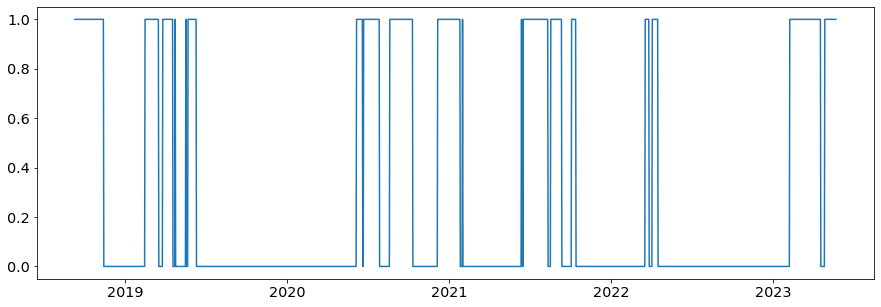

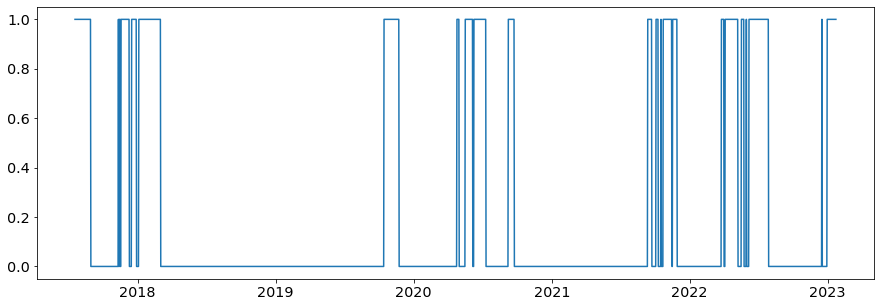

In [139]:
_id = 3046035
plt.figure()
plt.plot(treatment_ts_full_range[treatment_ts_full_range['locus_id'] == _id]['event_date'],
         treatment_ts_full_range[treatment_ts_full_range['locus_id'] == _id]['is_treated'])

_id = 3047027
plt.figure()
plt.plot(treatment_ts_full_range[treatment_ts_full_range['locus_id'] == _id]['event_date'],
         treatment_ts_full_range[treatment_ts_full_range['locus_id'] == _id]['is_treated'])

In [57]:
import gc 
gc.collect()

0

In [58]:
%whos DataFrame

Variable                           Type         Data/Info
---------------------------------------------------------
factors_merged                     DataFrame                             <...>            3532.000000  
final_locus_locus_group_weighted   DataFrame               final_locus_po<...>4787577 rows x 5 columns]
final_locus_weighted               DataFrame              final_locus_pop<...>1797577 rows x 4 columns]
fresh_water_dates                  DataFrame          pretransfer_fw_locu<...>\n[5890 rows x 5 columns]
locus_group_matching               DataFrame          locus_group_id  loc<...>\n[9308 rows x 2 columns]
locus_weights                      DataFrame             final_locus_popu<...>2092666 rows x 6 columns]
lw_dates                           DataFrame                             <...>\n[4192 rows x 4 columns]
mortality                          DataFrame          locus_id  fish_grou<...>n[1408 rows x 39 columns]
sw_fw_matching                     DataFrame        

In [62]:
tmp_list = ['is_treated','is_BRONOPOL','is_CLORAMINA T','is_Lufenurón','is_NACL','is_SAPROSAFE AW','is_Bath','is_Baño sin PMV','is_Feed']
#short_list = [x for x in treatment_ts_full_range.columns if x not in tmp_list]
short_list = [x for x in treatment_ts_full_range.columns if 'is_' in x]
#short_list = ['is_treated']

In [63]:
treatment_ts_full_range.columns

Index(['locus_id', 'event_date', 'level_1', 'is_treated', 'is_BRONOPOL',
       'is_CLORAMINA T', 'is_Lufenurón', 'is_NACL', 'is_SAPROSAFE AW',
       'is_Bath', 'is_Baño sin PMV', 'is_Feed', 'is_no_reason', 'is_caligus ',
       'is_flavobacteria', 'is_ipn', 'is_micosis', 'is_otro',
       'is_prescription'],
      dtype='object')

In [64]:
short_list

['is_treated',
 'is_BRONOPOL',
 'is_CLORAMINA T',
 'is_Lufenurón',
 'is_NACL',
 'is_SAPROSAFE AW',
 'is_Bath',
 'is_Baño sin PMV',
 'is_Feed',
 'is_no_reason',
 'is_caligus ',
 'is_flavobacteria',
 'is_ipn',
 'is_micosis',
 'is_otro',
 'is_prescription']

In [65]:
treatment_ts_full_range = pd.read_csv('..\\data\\treatment_ts_full_range.csv')
treatment_ts_full_range=treatment_ts_full_range.iloc[:,1:]
treatment_ts_full_range['event_date']=pd.to_datetime(treatment_ts_full_range['event_date'])

<AxesSubplot:>

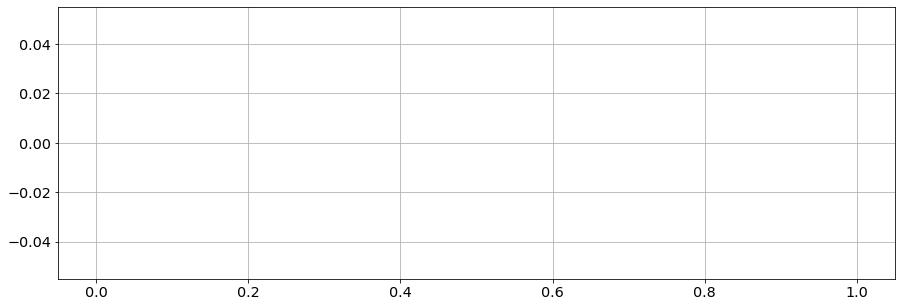

In [145]:
treatment_ts_full_range[treatment_ts_full_range.is_ipn==1].event_date.hist(bins=100)

In [66]:
#print(treatment_ts_full_range.is_treated.mean())
#print(treatment_ts_full_range.is_micosis.mean())

In [67]:
#np.mean(treatment_ts_full_range.groupby('locus_id').is_treated.mean())

In [68]:
#treatment_ts_full_range.columns

In [69]:
list_substances=['is_BRONOPOL', 'is_CLORAMINA T',
       'is_Lufenurón', 'is_NACL', 'is_SAPROSAFE AW']
list_reasons = ['is_no_reason', 'is_caligus ',
       'is_flavobacteria', 'is_ipn', 'is_micosis', 'is_otro']

In [70]:
list_substances + list_reasons

['is_BRONOPOL',
 'is_CLORAMINA T',
 'is_Lufenurón',
 'is_NACL',
 'is_SAPROSAFE AW',
 'is_no_reason',
 'is_caligus ',
 'is_flavobacteria',
 'is_ipn',
 'is_micosis',
 'is_otro']

In [71]:
counts_table = treatment_ts_full_range.pivot_table(index=list_substances, columns=list_reasons, aggfunc='size', fill_value=0)
counts_table = counts_table[1:]

In [72]:
treatment_ts_full_range[treatment_ts_full_range.is_BRONOPOL==1][list_reasons].mean()

is_no_reason        NaN
is_caligus          NaN
is_flavobacteria    NaN
is_ipn              NaN
is_micosis          NaN
is_otro             NaN
dtype: object

In [150]:
treatment_ts_full_range[treatment_ts_full_range['is_SAPROSAFE AW']==1][list_reasons].mean()

is_no_reason        NaN
is_caligus          NaN
is_flavobacteria    NaN
is_ipn              NaN
is_micosis          NaN
is_otro             NaN
dtype: object

In [ ]:
treatment_ts_full_range[treatment_ts_full_range['is_BRONOPOL']==1].groupby('event_year')[list_reasons].mean()

In [ ]:
treatment_ts_full_range[treatment_ts_full_range['is_SAPROSAFE AW']==1].groupby('event_year')[list_reasons].mean()

In [151]:
treatment_ts_full_range['event_year'] = treatment_ts_full_range['event_date'].dt.year

In [ ]:
treatment_ts_full_range[treatment_ts_full_range['is_CLORAMINA T']==1].groupby('event_year')[list_reasons].mean()

In [ ]:
tmp_locus = treatment_ts_full_range[treatment_ts_full_range.locus_id==3046035]
sns.lineplot(data=tmp_locus,x='event_date',y='is_micosis')

In [73]:
short_list

['is_treated',
 'is_BRONOPOL',
 'is_CLORAMINA T',
 'is_Lufenurón',
 'is_NACL',
 'is_SAPROSAFE AW',
 'is_Bath',
 'is_Baño sin PMV',
 'is_Feed',
 'is_no_reason',
 'is_caligus ',
 'is_flavobacteria',
 'is_ipn',
 'is_micosis',
 'is_otro',
 'is_prescription']

In [75]:
# treatment_ts_full_range_flp = treatment_ts_full_range.merge(final_locus_weighted,
treatment_ts_full_range_flp = treatment_ts_full_range[short_list + ['event_date', 'locus_id']].merge(final_locus_weighted,
                   how='inner', 
                   left_on=['event_date', 'locus_id'],
                   right_on=['event_date', 'historic_locus_id'])
is_cols = [col for col in treatment_ts_full_range_flp.columns if 'is_' in col]    


In [76]:
is_cols

['is_treated',
 'is_BRONOPOL',
 'is_CLORAMINA T',
 'is_Lufenurón',
 'is_NACL',
 'is_SAPROSAFE AW',
 'is_Bath',
 'is_Baño sin PMV',
 'is_Feed',
 'is_no_reason',
 'is_caligus ',
 'is_flavobacteria',
 'is_ipn',
 'is_micosis',
 'is_otro',
 'is_prescription']

In [77]:
for col in is_cols:
    try:
        
        treatment_ts_full_range_flp[f'{col}_weighted'] = \
        treatment_ts_full_range_flp['weight'] * treatment_ts_full_range_flp[col]
    except TypeError:
        treatment_ts_full_range_flp[f'{col}_weighted'] = \
        treatment_ts_full_range_flp['weight'] * treatment_ts_full_range_flp[col].astype(bool)


In [78]:
#Optimized!
sum_columns = [f'{col}_weighted' for col in is_cols]
# Fill NaN values with 0 before the groupby operation
treatment_ts_full_range_flp_filled = treatment_ts_full_range_flp.fillna(0)
# Perform the groupby and sum operation
treatment_ts_full_range_flp_grouped = treatment_ts_full_range_flp_filled.groupby(['final_locus_population_id', 'event_date'])[sum_columns].sum().reset_index()

In [79]:
#Memory error!!!!
# treatment_ts_full_range_flp_grouped = treatment_ts_full_range_flp.\
# groupby(['final_locus_population_id','event_date'])[[f'{col}_weighted' for col in is_cols]]\
# .agg(lambda x: x.sum(skipna=False)).reset_index()

In [80]:
len(treatment_ts_full_range_flp)

41009666

In [81]:
len(final_locus_weighted)

41797577

In [82]:
len(treatment_ts_full_range)

1303687

In [183]:
treatment_ts_full_range[treatment_ts_full_range.locus_id == 3046261]#.is_treated.mean()

,locus_id,event_date,level_1,is_treated,is_BRONOPOL,is_CLORAMINA T,is_Lufenurón,is_NACL,is_SAPROSAFE AW,is_Bath,is_Baño sin PMV,is_Feed,is_no_reason,is_caligus,is_flavobacteria,is_ipn,is_micosis,is_otro,is_prescription,event_year
27122,3046261,2015-01-06,0,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0,2015
27123,3046261,2015-01-07,1,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0,2015
27124,3046261,2015-01-08,2,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0,2015
27125,3046261,2015-01-09,3,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0,2015
27126,3046261,2015-01-10,4,1.0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30365,3046261,2023-11-23,3487,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2023
30366,3046261,2023-11-24,3488,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2023
30367,3046261,2023-11-25,3489,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2023
30368,3046261,2023-11-26,3490,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2023


In [83]:
treatment_ts_full_range_flp[treatment_ts_full_range_flp.locus_id == 3046261]#.is_treated.mean()

,is_treated,is_BRONOPOL,is_CLORAMINA T,is_Lufenurón,is_NACL,is_SAPROSAFE AW,is_Bath,is_Baño sin PMV,is_Feed,is_no_reason,...,is_Bath_weighted,is_Baño sin PMV_weighted,is_Feed_weighted,is_no_reason_weighted,is_caligus _weighted,is_flavobacteria_weighted,is_ipn_weighted,is_micosis_weighted,is_otro_weighted,is_prescription_weighted
642589,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
642590,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
642591,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
642592,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
642593,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811644,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
811645,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
811646,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
811647,0.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
treatment_ts_full_range_flp[treatment_ts_full_range_flp.final_locus_population_id == 36770651].sort_values(by='event_date').tail(100)

,is_treated,is_BRONOPOL,is_CLORAMINA T,is_Lufenurón,is_NACL,is_SAPROSAFE AW,is_Bath,is_Baño sin PMV,is_Feed,is_no_reason,...,is_Bath_weighted,is_Baño sin PMV_weighted,is_Feed_weighted,is_no_reason_weighted,is_caligus _weighted,is_flavobacteria_weighted,is_ipn_weighted,is_micosis_weighted,is_otro_weighted,is_prescription_weighted
17508905,1.0,0,0,0,1,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37520547,1.0,0,0,0,1,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17508910,1.0,0,0,0,1,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37520554,1.0,0,0,0,1,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37520561,1.0,0,0,0,1,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7930475,1.0,False,False,False,True,False,True,False,False,False,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7930477,1.0,False,False,False,True,False,True,False,False,False,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7930479,1.0,False,False,False,True,False,True,False,False,False,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7930481,1.0,False,False,False,True,False,True,False,False,False,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [186]:
treatment_ts_full_range_flp[treatment_ts_full_range_flp.locus_id == 3046261].is_treated_weighted.mean()

AttributeError: 'DataFrame' object has no attribute 'is_treated_weighted'

In [ ]:
check=treatment_ts_full_range_flp[treatment_ts_full_range_flp.final_locus_population_id==36770651]

In [187]:
check[check.event_date=='2015-11-23']

NameError: name 'check' is not defined

In [188]:
treatment_ts_full_range_flp_grouped['weight_sum'] = treatment_ts_full_range_flp_grouped[['is_treated_weighted']].sum(axis=1)

KeyError: "None of [Index(['is_treated_weighted'], dtype='object')] are in the [columns]"

In [189]:
np.mean(treatment_ts_full_range_flp_grouped.groupby('final_locus_population_id').is_treated_weighted.mean())

AttributeError: 'DataFrameGroupBy' object has no attribute 'is_treated_weighted'

In [190]:
treatment_ts_full_range_flp_grouped.is_treated_weighted.describe()

AttributeError: 'DataFrame' object has no attribute 'is_treated_weighted'

In [ ]:
# (treatment_ts_full_range_flp.groupby(['final_locus_population_id','event_date'])['weight'].sum()).describe()

In [191]:
treatment_ts_full_range_flp

,locus_id,event_date,level_1,is_no_reason,is_caligus,is_flavobacteria,is_ipn,is_micosis,is_otro,is_prescription,final_locus_population_id,historic_locus_id,weight,is_no_reason_weighted,is_caligus _weighted,is_flavobacteria_weighted,is_ipn_weighted,is_micosis_weighted,is_otro_weighted,is_prescription_weighted
0,3046035,2018-09-10,0,False,False,False,False,True,False,0.0,36787705,3046035,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,3046035,2018-09-11,1,False,False,False,False,True,False,0.0,36787705,3046035,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,3046035,2018-09-12,2,False,False,False,False,True,False,0.0,36787705,3046035,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,3046035,2018-09-13,3,False,False,False,False,True,False,0.0,36787705,3046035,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,3046035,2018-09-14,4,False,False,False,False,True,False,0.0,36787705,3046035,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41009661,7184140,2022-09-19,26,False,False,False,False,True,False,0.0,194521576,7184140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41009662,7184140,2022-09-19,26,False,False,False,False,True,False,0.0,194521584,7184140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41009663,7184140,2022-09-19,26,False,False,False,False,True,False,0.0,194521595,7184140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
41009664,7184140,2022-09-19,26,False,False,False,False,True,False,0.0,194521608,7184140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [85]:
import gc; gc.collect()

362

In [86]:

# # treatment_ts_full_range_flp = treatment_ts_full_range.merge(final_locus_weighted,
# treatment_ts_full_range_flp = treatment_ts_full_range[short_list].merge(final_locus_weighted,
#                    how='inner', 
#                    left_on=['event_date', 'locus_id'],
#                    right_on=['event_date', 'historic_locus_id'])

# # fw_mortality_final_lp['event_year'] = fw_mortality_final_lp['event_date'].dt.year

# is_cols = [col for col in treatment_ts_full_range_flp.columns if 'is_' in col]    
# for col in is_cols:
#     treatment_ts_full_range_flp[f'{col}_weighted'] = \
#     treatment_ts_full_range_flp['weight'] * treatment_ts_full_range_flp[col]

# treatment_ts_full_range_flp_grouped = treatment_ts_full_range_flp.\
# groupby(['final_locus_population_id','event_date'])[[f'{col}_weighted' for col in is_cols]]\
# .agg(lambda x: x.sum(skipna=False)).reset_index()

# for col in is_cols:
#     treatment_ts_full_range_flp_grouped.rename(
#         columns={f'{col}_weighted': col}, inplace=True
#     )

In [87]:
treatment_ts_full_range[short_list].columns

Index(['is_treated', 'is_BRONOPOL', 'is_CLORAMINA T', 'is_Lufenurón',
       'is_NACL', 'is_SAPROSAFE AW', 'is_Bath', 'is_Baño sin PMV', 'is_Feed',
       'is_no_reason', 'is_caligus ', 'is_flavobacteria', 'is_ipn',
       'is_micosis', 'is_otro', 'is_prescription'],
      dtype='object')

In [88]:
# # tqdm.pandas(desc='grouping on final_locus_population lvl')

# treatment_ts_full_range_flp_grouped = treatment_ts_full_range_flp.\
# groupby(['final_locus_population_id','event_date'])[[f'{col}_weighted' for col in is_cols]]\
# .apply(lambda x: x.sum(skipna=False)).reset_index()
# # .progress_apply(lambda x: x.sum(skipna=False)).reset_index()


# for col in is_cols:
#     treatment_ts_full_range_flp_grouped.rename(
#         columns={f'{col}_weighted': col}, inplace=True
#     )

In [196]:
treatment_ts_full_range_flp_grouped.sum()

TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'sum'

In [89]:
treatment_ts_full_range_flp_grouped

,final_locus_population_id,event_date,is_treated_weighted,is_BRONOPOL_weighted,is_CLORAMINA T_weighted,is_Lufenurón_weighted,is_NACL_weighted,is_SAPROSAFE AW_weighted,is_Bath_weighted,is_Baño sin PMV_weighted,is_Feed_weighted,is_no_reason_weighted,is_caligus _weighted,is_flavobacteria_weighted,is_ipn_weighted,is_micosis_weighted,is_otro_weighted,is_prescription_weighted
0,36770651,2015-09-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36770651,2015-09-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36770651,2015-09-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36770651,2015-09-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36770651,2015-09-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604113,194761283,2023-12-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1604114,194761283,2023-12-04,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1604115,194761283,2023-12-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1604116,194761283,2023-12-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [90]:
treatment_ts_full_range_flp_grouped.to_csv('../data\\treatment_ts_full_range_flp_grouped_DE.csv', index=False)

In [200]:
dff=pd.read_csv('../data/treatment_ts_full_range_flp_grouped_DE.csv') #treatment_ts_full_range_flp_grouped_reasons_presc_DE
fwd=pd.read_csv('../data/FW_cycle_dates.csv')

In [201]:
dff=dff.merge(fwd, left_on='final_locus_population_id',right_on='pretransfer_fw_locus_population_id')

In [202]:
dff['event_date']=pd.to_datetime(dff['event_date'])
dff['first_feeding_date']=pd.to_datetime(dff['first_feeding_date'])


In [204]:
sfm = pd.read_csv('../data/seawater_freshwater_matching.csv')

In [205]:
sfm['transport_date']=pd.to_datetime(sfm['transport_date'])
sfm['transfer_year']=sfm['transport_date'].dt.year

In [207]:
targets = pd.read_csv('../data/targets.csv')
targets.columns

Index(['locus_id', 'fish_group_id', 'transfer_year', 'stocking_weight',
       'total_mortality_perc_90', 'transport_mortality_perc_90',
       'nontransport_mortality_perc_90', 'oSFR', 'nSFR'],
      dtype='object')

In [208]:
dff.head()

,final_locus_population_id,event_date,is_no_reason_weighted,is_caligus _weighted,is_flavobacteria_weighted,is_ipn_weighted,is_micosis_weighted,is_otro_weighted,is_prescription_weighted,pretransfer_fw_locus_population_id,pretransfer_fw_locus_id,first_movement_date,first_feeding_date,shipout_date
0,36770651,2015-09-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36770651,3047255,2015-05-15,2015-11-17,2016-07-07
1,36770651,2015-09-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36770651,3047255,2015-05-15,2015-11-17,2016-07-07
2,36770651,2015-09-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36770651,3047255,2015-05-15,2015-11-17,2016-07-07
3,36770651,2015-09-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36770651,3047255,2015-05-15,2015-11-17,2016-07-07
4,36770651,2015-09-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36770651,3047255,2015-05-15,2015-11-17,2016-07-07


In [210]:
dff_=dff.merge(sfm[['pretransfer_fw_locus_population_id','target_seawater_locus_id','transfer_year']],
         left_on='final_locus_population_id',right_on='pretransfer_fw_locus_population_id').merge\
(targets[['locus_id', 'fish_group_id', 'transfer_year',]],left_on=['target_seawater_locus_id','transfer_year'],right_on=['locus_id','transfer_year'])

In [211]:
sns.set_style('whitegrid')
for flp in dff[dff.is_ipn>0].final_locus_population_id.unique():
    plt.figure()
    tmp=dff_[dff_.final_locus_population_id==flp]
    if len(tmp)>0: 
        plt.plot(tmp.event_date,tmp.is_ipn)
        plt.axvline(tmp.first_feeding_date.iloc[0], color='red', linestyle='dashed')
        plt.axvline(tmp.first_feeding_date.iloc[0]+pd.Timedelta(28,'d'), color='red', linestyle='dashed')
        plt.title(f'population_id={flp}, TGC={round(tmp.TGC_SW.iloc[0],2)}')
        plt.savefig(f'Visualisation\\ipn_case\\population_id={flp}, TGC={round(tmp.TGC_SW.iloc[0],2)}.jpg')

AttributeError: 'DataFrame' object has no attribute 'is_ipn'

In [212]:
tmp

NameError: name 'tmp' is not defined

In [213]:
treatment_ts_full_range_flp_grouped.columns

Index(['final_locus_population_id', 'event_date', 'is_no_reason_weighted',
       'is_caligus _weighted', 'is_flavobacteria_weighted', 'is_ipn_weighted',
       'is_micosis_weighted', 'is_otro_weighted', 'is_prescription_weighted'],
      dtype='object')